In [ ]:
# UANL - FCFM
# Aprendizaje Automático
# Francisco Treviño
# 2024-07-20

In [2]:
# NYC Taxi and Limousine Commission
# TLC Trip Record Data
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet

In [3]:
# !pip install pyarrow

In [4]:
# !pip install fpdf

In [5]:
# !pip install pandas numpy scikit-learn matplotlib seaborn

In [6]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.cluster import KMeans
# import shap
# from sklearn.decomposition import PCA
# from scipy.stats import kstest, shapiro
# import pingouin as pg

In [7]:
# Configuración para desactivar la notación científica
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [8]:
df = pq.read_table('./NYC - Trip Records/yellow_tripdata_2024-04.parquet')
df = df.to_pandas()

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-04-01 00:02:40,2024-04-01 00:30:42,0.00,5.20,1.00,N,161,7,1,29.60,3.50,0.50,8.65,0.00,1.00,43.25,2.50,0.00
1,2,2024-04-01 00:41:12,2024-04-01 00:55:29,1.00,5.60,1.00,N,264,264,1,25.40,1.00,0.50,10.00,0.00,1.00,37.90,0.00,0.00
2,2,2024-04-01 00:48:42,2024-04-01 01:05:30,1.00,3.55,1.00,N,186,236,1,20.50,1.00,0.50,5.10,0.00,1.00,30.60,2.50,0.00
3,2,2024-04-01 00:56:02,2024-04-01 01:05:09,1.00,1.06,1.00,N,137,164,2,10.00,1.00,0.50,0.00,0.00,1.00,15.00,2.50,0.00
4,1,2024-04-01 00:08:32,2024-04-01 00:10:24,1.00,0.70,1.00,N,236,263,1,5.10,3.50,0.50,2.00,0.00,1.00,12.10,2.50,0.00


In [10]:
df.count()

VendorID                 3514289
tpep_pickup_datetime     3514289
tpep_dropoff_datetime    3514289
passenger_count          3105713
trip_distance            3514289
RatecodeID               3105713
store_and_fwd_flag       3105713
PULocationID             3514289
DOLocationID             3514289
payment_type             3514289
fare_amount              3514289
extra                    3514289
mta_tax                  3514289
tip_amount               3514289
tolls_amount             3514289
improvement_surcharge    3514289
total_amount             3514289
congestion_surcharge     3105713
Airport_fee              3105713
dtype: int64

In [11]:
# LocationID,Borough,Zone,service_zone
# 138,"Queens","LaGuardia Airport","Airports"
query = 'PULocationID == 138'
df = df.query(query)
df.count()

VendorID                 111164
tpep_pickup_datetime     111164
tpep_dropoff_datetime    111164
passenger_count          110553
trip_distance            111164
RatecodeID               110553
store_and_fwd_flag       110553
PULocationID             111164
DOLocationID             111164
payment_type             111164
fare_amount              111164
extra                    111164
mta_tax                  111164
tip_amount               111164
tolls_amount             111164
improvement_surcharge    111164
total_amount             111164
congestion_surcharge     110553
Airport_fee              110553
dtype: int64

In [12]:
zone_file_path = './NYC - Trip Records/taxi_zone_lookup.csv'
zones_df = pd.read_csv(zone_file_path)

df = df.merge(zones_df, how='left', left_on='PULocationID', right_on='LocationID', suffixes=('', '_pickup'))
df = df.merge(zones_df, how='left', left_on='DOLocationID', right_on='LocationID', suffixes=('', '_dropoff'))

df.drop(columns=['LocationID', 'LocationID_dropoff'], inplace=True)

In [13]:
query = ' Borough_dropoff == "Manhattan" '
df = df.query(query)

In [14]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Borough,Zone,service_zone,Borough_dropoff,Zone_dropoff,service_zone_dropoff
1,2,2024-04-01 00:21:38,2024-04-01 00:36:02,1.00,7.76,1.00,N,138,263,2,...,1.00,48.99,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Yorkville West,Yellow Zone
2,1,2024-04-01 00:04:50,2024-04-01 00:23:32,1.00,11.50,1.00,N,138,24,1,...,1.00,72.54,0.00,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Bloomingdale,Yellow Zone
5,1,2024-04-01 00:02:28,2024-04-01 00:19:23,1.00,9.70,1.00,N,138,237,1,...,1.00,64.28,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Upper East Side South,Yellow Zone
7,2,2024-04-01 00:01:06,2024-04-01 00:22:48,2.00,10.22,1.00,N,138,239,1,...,1.00,70.19,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,Upper West Side South,Yellow Zone
9,2,2024-04-01 00:18:35,2024-04-01 00:36:08,1.00,9.40,1.00,N,138,233,1,...,1.00,66.84,2.50,1.75,Queens,LaGuardia Airport,Airports,Manhattan,UN/Turtle Bay South,Yellow Zone


In [15]:
df.count()

VendorID                 77870
tpep_pickup_datetime     77870
tpep_dropoff_datetime    77870
passenger_count          77348
trip_distance            77870
RatecodeID               77348
store_and_fwd_flag       77348
PULocationID             77870
DOLocationID             77870
payment_type             77870
fare_amount              77870
extra                    77870
mta_tax                  77870
tip_amount               77870
tolls_amount             77870
improvement_surcharge    77870
total_amount             77870
congestion_surcharge     77348
Airport_fee              77348
Borough                  77870
Zone                     77870
service_zone             77870
Borough_dropoff          77870
Zone_dropoff             77870
service_zone_dropoff     77870
dtype: int64

In [16]:
# Eliminar filas con NaNs
df = df.dropna()

In [17]:
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
df['payment_type'] = df['payment_type'].fillna(1)
df['passenger_count'] = df['passenger_count'].fillna(1)
df['RatecodeID'] = df['RatecodeID'].fillna(1)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')
df['Airport_fee'] = df['Airport_fee'].fillna(0)

In [18]:
nan_columns = df.columns[df.isna().any()].tolist()
print(f'Columnas con NaNs: {nan_columns}')
print(df[df.isna().any(axis=1)])

Columnas con NaNs: []
Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, Airport_fee, Borough, Zone, service_zone, Borough_dropoff, Zone_dropoff, service_zone_dropoff]
Index: []

[0 rows x 25 columns]


In [19]:
df['trip_duration_seconds'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['dropoff_date'] = df['tpep_dropoff_datetime'].dt.date

df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.day

df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['pickup_second'] = df['tpep_pickup_datetime'].dt.second

df['dropoff_day_of_week'] = df['tpep_dropoff_datetime'].dt.dayofweek
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour
df['dropoff_minute'] = df['tpep_dropoff_datetime'].dt.minute
df['dropoff_second'] = df['tpep_dropoff_datetime'].dt.second

df['pickup_time'] = df['pickup_hour'].astype(str).str.zfill(2) + ':' + df['pickup_minute'].astype(str).str.zfill(2)
df['dropoff_time'] = df['dropoff_hour'].astype(str).str.zfill(2) + ':' + df['dropoff_minute'].astype(str).str.zfill(2)

df['day_change'] = (df['tpep_pickup_datetime'].dt.date != df['tpep_dropoff_datetime'].dt.date).astype(int)

In [20]:
df.loc[:, 'misc_charges'] = (
    df['extra'] + 
    df['mta_tax'] + 
    df['improvement_surcharge'] + 
    df['tolls_amount'] + 
    df['congestion_surcharge'] +
    df['Airport_fee']    
)

In [21]:
df.loc[:, 'total_amount_calc'] = (df['fare_amount'] + df['extra'] + df['mta_tax'] + df['improvement_surcharge'] + df['tip_amount'] + df['tolls_amount'] + df['congestion_surcharge'] + df['Airport_fee'])

In [22]:
df['total_amount_diff'] = df['total_amount_calc'] - df['total_amount']

In [23]:
df['tip_percent'] = (df['tip_amount'] / df['fare_amount']) * 100
df['misc_charges_percent'] = (df['misc_charges'] / df['fare_amount']) * 100
df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60.00
df['pickup_hour_in_minutes'] = df['pickup_hour'] * 60 + df['pickup_minute'] + df['pickup_second'] / 60.00

In [24]:
df['average_speed'] = np.where(df['trip_duration_minutes'] > 0, 
                               df['trip_distance'] / (df['trip_duration_minutes'] / 60), 0)

In [25]:
# Limpiar registros con datos inválidos, valores negativos
query = ' trip_distance > 0 '
query += ' and tip_amount >= 0 '
query += ' and extra >= 0 '
query += ' and mta_tax >= 0 '
query += ' and tolls_amount >= 0'
query += ' and improvement_surcharge >= 0'
query += ' and congestion_surcharge >= 0'
query += ' and trip_duration_seconds > 0'
query += ' and fare_amount > 0'
query += ' and total_amount > 0' 

df = df.query(query)

In [26]:
# Limpiar registros con datos inválidos, valores negativos y fuera de rango en el limite superior
query = ' trip_distance <= 50 '
query += ' and trip_duration_minutes <= 60'
query += ' and total_amount <= 100 '
query += ' and fare_amount <= 100 '
query += ' and tip_percent <= 50 '

df = df.query(query)

In [27]:
query = 'trip_distance >= 5 and trip_distance <= 15'
df = df.query(query)

In [28]:
query = 'payment_type == 1'
query += ' and passenger_count == 1'
query += ' and RatecodeID == 1'

df = df.query(query)

In [29]:
# Semana del domingo 14 al sabado 20 de abril 2024
query = ' pickup_day >= 14 and pickup_day <= 20'

df = df.query(query)

In [30]:
df.count()

VendorID                  12986
tpep_pickup_datetime      12986
tpep_dropoff_datetime     12986
passenger_count           12986
trip_distance             12986
RatecodeID                12986
store_and_fwd_flag        12986
PULocationID              12986
DOLocationID              12986
payment_type              12986
fare_amount               12986
extra                     12986
mta_tax                   12986
tip_amount                12986
tolls_amount              12986
improvement_surcharge     12986
total_amount              12986
congestion_surcharge      12986
Airport_fee               12986
Borough                   12986
Zone                      12986
service_zone              12986
Borough_dropoff           12986
Zone_dropoff              12986
service_zone_dropoff      12986
trip_duration_seconds     12986
pickup_date               12986
dropoff_date              12986
pickup_day                12986
dropoff_day               12986
pickup_day_of_week        12986
pickup_h

In [31]:
# Función para calcular estadísticas descriptivas
def descriptive_stats(df, variables):
    stats = {}
    for var in variables:
        stats[var] = {
            'Min': df[var].min(),
            'Max': df[var].max(),
            'Median': df[var].median(),
            'Mode': df[var].mode()[0],
            'Mean': df[var].mean(),
            'Std': df[var].std(),
            'Count': df[var].count()
        }
    return pd.DataFrame(stats)

In [32]:
# Crear variable de clasificación: si la propina es mayor a 0
df['tip_given'] = (df['tip_amount'] > 0).astype(int)
df['same_location'] = (df['PULocationID'] == df['DOLocationID']).astype(int)
df['paid_tolls'] = (df['tolls_amount'] > 0).astype(int)
df['same_day'] = (df['pickup_day'] == df['dropoff_day']).astype(int)

In [33]:
def peak_hour_class(hour):
    if 7 <= hour <= 9:
        return 'Morning Peak'
    elif 16 <= hour <= 18:
        return 'Evening Peak'
    else:
        return 'Off-Peak'

df['pickup_hour_class'] = df['pickup_hour'].apply(peak_hour_class)

In [34]:
df['cluster'] = 0

In [35]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,misc_charges_percent,trip_duration_minutes,pickup_hour_in_minutes,average_speed,tip_given,same_location,paid_tolls,same_day,pickup_hour_class,cluster
46599,2,2024-04-14 00:17:33,2024-04-14 00:37:24,1.00,9.09,1.00,N,138,239,1,...,49.18,19.85,17.55,27.48,1,0,1,1,Off-Peak,0
46601,2,2024-04-14 00:11:28,2024-04-14 00:30:26,1.00,8.51,1.00,N,138,100,1,...,53.10,18.97,11.47,26.92,1,0,1,1,Off-Peak,0
46602,2,2024-04-14 00:07:33,2024-04-14 00:24:21,1.00,8.31,1.00,N,138,116,1,...,26.81,16.80,7.55,29.68,1,0,0,1,Off-Peak,0
46603,2,2024-04-14 00:06:25,2024-04-14 00:26:10,1.00,8.56,1.00,N,138,116,1,...,45.99,19.75,6.42,26.01,1,0,1,1,Off-Peak,0
46604,1,2024-04-14 00:59:02,2024-04-14 01:23:11,1.00,9.70,1.00,N,138,143,1,...,60.37,24.15,59.03,24.10,1,0,1,1,Off-Peak,0


In [36]:
df.to_csv('./csv/subset_4_yellow_tripdata_2024-04.csv', index=False)

In [37]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,misc_charges_percent,trip_duration_minutes,pickup_hour_in_minutes,average_speed,tip_given,same_location,paid_tolls,same_day,pickup_hour_class,cluster
46599,2,2024-04-14 00:17:33,2024-04-14 00:37:24,1.00,9.09,1.00,N,138,239,1,...,49.18,19.85,17.55,27.48,1,0,1,1,Off-Peak,0
46601,2,2024-04-14 00:11:28,2024-04-14 00:30:26,1.00,8.51,1.00,N,138,100,1,...,53.10,18.97,11.47,26.92,1,0,1,1,Off-Peak,0
46602,2,2024-04-14 00:07:33,2024-04-14 00:24:21,1.00,8.31,1.00,N,138,116,1,...,26.81,16.80,7.55,29.68,1,0,0,1,Off-Peak,0
46603,2,2024-04-14 00:06:25,2024-04-14 00:26:10,1.00,8.56,1.00,N,138,116,1,...,45.99,19.75,6.42,26.01,1,0,1,1,Off-Peak,0
46604,1,2024-04-14 00:59:02,2024-04-14 01:23:11,1.00,9.70,1.00,N,138,143,1,...,60.37,24.15,59.03,24.10,1,0,1,1,Off-Peak,0


X_clust_scaled shape: (12986, 4)
First few rows of X_clust_scaled:
[[-0.40983072 -1.07637568  1.05969416  0.16764682]
 [-0.80287686 -1.15873265 -1.05686123  0.16764682]
 [-0.93841002 -1.36074034 -0.81322895  0.16764682]
 [-0.76899357 -1.08569911 -0.81322895  0.16764682]
 [ 0.0035454  -0.67546812 -0.40209949  0.16764682]]


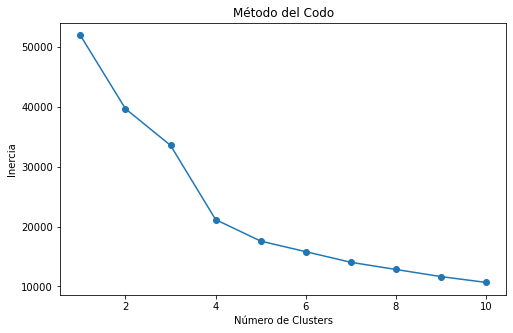

         trip_distance  trip_duration_minutes  DOLocationID  tip_given  \
cluster                                                                  
0                11.55                  35.89        206.67       1.00   
1                 8.95                  24.42        240.68       1.00   
2                 8.70                  26.74         67.64       1.00   
3                 9.79                  33.58        161.59       0.00   
4                 9.62                  44.93        180.95       1.00   
5                 9.14                  24.16        151.22       1.00   
6                12.11                  38.54         79.97       1.00   

         cluster  
cluster           
0           0.00  
1           1.00  
2           2.00  
3           3.00  
4           4.00  
5           5.00  
6           6.00  
Cluster summary saved to 'cluster_summary.csv'


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Seleccionar variables relevantes para clustering
features_clustering = [
    'trip_distance',
    'trip_duration_minutes',
    'DOLocationID',
    'tip_given'
]

# Escalar las características
scaler = StandardScaler()
X_clust_scaled = scaler.fit_transform(df[features_clustering])

print(f'X_clust_scaled shape: {X_clust_scaled.shape}')
print(f'First few rows of X_clust_scaled:\n{X_clust_scaled[:5]}')

# Determinar el número óptimo de clusters usando el método del codo
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_clust_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
df['cluster'] = kmeans.fit_predict(X_clust_scaled)

for col in features_clustering:
    if col not in df.columns:
        raise ValueError(f'Column {col} not found in dataframe')
    if not np.issubdtype(df[col].dtype, np.number):
        raise ValueError(f'Column {col} is not numeric')

# Calcular el resumen de los clusters solo con columnas numéricas
numeric_columns = df[features_clustering + ['cluster']].select_dtypes(include=[np.number]).columns
cluster_summary = df.groupby('cluster')[numeric_columns].mean()

print(cluster_summary)

# Guardar los resultados en un archivo CSV
cluster_summary.to_csv('./csv/cluster_summary.csv', index=True)
print("Cluster summary saved to 'cluster_summary.csv'")


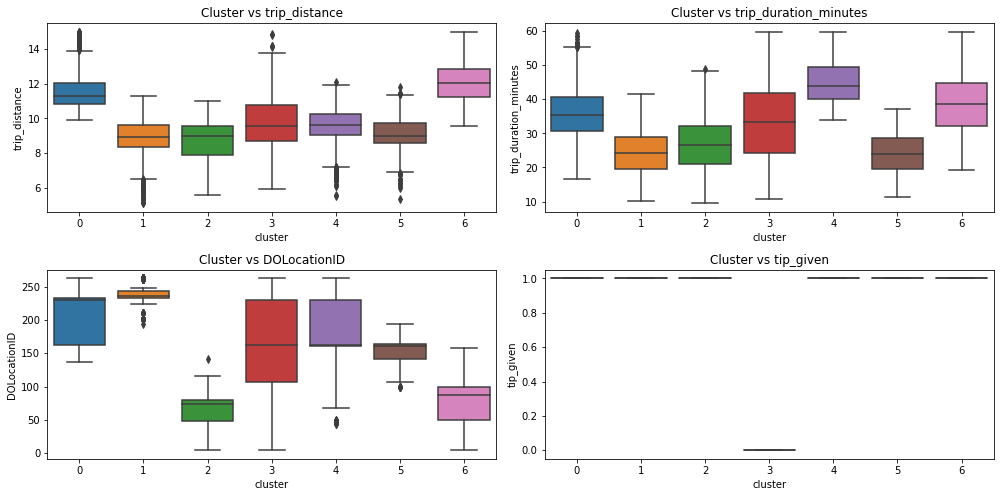

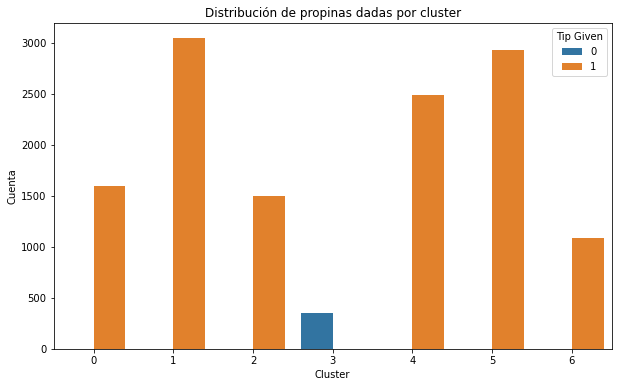

In [41]:
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_clustering, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'Cluster vs {feature}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='tip_given', data=df)
plt.title('Distribución de propinas dadas por cluster')
plt.xlabel('Cluster')
plt.ylabel('Cuenta')
plt.legend(title='Tip Given', loc='upper right')
plt.show()